# Assignment 3a Cognitive Modelling

Dit is onderdeel van de derde opdracht voor Cognitive Modelling, assignment 3 bestaat in totaal uit 3 onderdelen:

* __Assignment 3a (43 punten)__
* Assignment 3b (21 punten)
* Assignment 3c (23 punten)

__Let op__: Opdracht 3b en 3c werken alleen in Google Colab!

Geef antwoorden in blokken met code of met tekst.Gebruik voor antwoorden met tekst de ">" voor blockquotes en geef bij elke vraag ook __kort uitleg__ als hier om wordt gevraagd. __Let op__: soms staan er meerdere vragen bij een onderdeel, lees de tekst dus nauwkeurig. 

Sla het uiteindelijke notebook op met jullie studentnummers en achternamen in de filenaam: `studentnummer_achternaam_opdrachtnummer`.

<br>

---

## Q-Learning:  State Spaces and Deep Q Networks

In de vorige opdrachten hebben we gekeken naar simpele taken waarbij de state space bekend was en de mogelijke acties ook. Vaak zijn omgevingen echter onbekend of een stuk ingewikkelder. We beginnen nu bij een kleine omgeving die verkend moet worden, maar die nog wel in een Q-table te vangen is. Let op dat steeds hierbij alle mogelijke handelingen wel duidelijk zijn, het is maar de vraag of dit voor biologische systemen ook het geval is.

We gaan ook kijken hoe we het klassieke Q-Learning (wat dus is gebaseerd op het Rescorla Wagner model) kunnen uitbreiden met functies die gebaseerd zijn op de werking van menselijke hersenen.

Uiteindelijk maken we een klein uitstapje naar Deep Q Networks: de huidige state-of-the-art methode in Reinforcement Learning, waar het basis Q-Learning idee wordt gecombineerd met dat van Deep Neural Nets, met name ConvNets. Aan het eind van deze opdracht moet je een goed idee hebben hoe deze Deep Q Nets werken, en ook begrijpen hoe je deze netwerken mogelijk kan aanpassen en ze slimmer te maken.

#### Winter is coming

Het is winter. Jij en je robotvriend waren in het park met een frisbee aan het spelen toen jij een wilde worp deed waardoor de frisbee midden op het meer terecht kwam. Het water is grotendeels goed bevroren, maar er zijn een paar zwakke plekken waar je door het ijs zakt en in het ijskoude water valt. <br>

![](Images\lake.png) <br>

Op dit moment is er een internationaal frisbeetekort, dus het is absoluut noodzakelijk dat je over het meer navigeert en de frisbee terughaalt. Omdat je zelf niet nat wilt worden, stuur je je robot om de frisbee te halen. Het oppervlak wordt beschreven met behulp van deze matrix:
    
        State:        State #:
        S F F F     0  1  2  3
        F H F H     4  5  6  7 
        F F F H     8  9  10 11 
        H F F G     12 13 14 15 
        
    S : start punt, safe
    F : bevroren surface, safe
    H : zwak ijs, val in het water (einde robot)
    G : Doel, de frisbee

Dit is de Frozenlake omgeving, een spel van de Open AI Gym. Dit spel wordt gebruikt als een soort benchmark om verschillende leeralgoritmes (vooral Q-learning) met elkaar te vergelijken. In deze Gym kan je nog veel meer leuke dingen vinden, en voor deze opdracht is het nodig om de gym library installeren.

`!pip install gym` zou genoeg moeten zijn, kijk anders even op https://gym.openai.com/docs/#installation

Daarnaast gebruikt de gym ook nog wat elementen van `pygame` dus installeer dat ook:

`!pip install pygame`  of kijk op https://www.pygame.org/wiki/GettingStarted 

In [1]:
# !pip install gym

In [2]:
# !pip install pygame

In [3]:
# init gym and other libraries
import gym
import pygame
import math
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

#### Loading the environment

In [4]:
# We laden nu een 4x4 Frozen Lake. Slippery betekent dat de robot soms uitglijdt en een random kant op beweegt 
# We start with non slippery ice 🤔
env_4x4 = gym.make('FrozenLake-v1', desc=None,map_name="4x4", is_slippery=False)

<br>

---

## 1. Q-Table learning

Het is jouw taak om de robot te leren veilig van start $S$ naar het doel $G$ te lopen door middel van Q learning. Daarmee voorkom je dat de robot in een wak valt.

Details over Q-learning zijn terug te vinden in de college slides en in het hoofdstuk van Gureckis & Love [**Computational reinforcement learning**](http://bradlove.org/papers/GureckisLovePress.pdf), voor meer verdieping in het online boek van [**Sutton & Barto**](http://incompleteideas.net/book/bookdraft2018jan1.pdf) en dan met name hoofdstuk 6.


**Let op:** In dit experiment zijn meerdere states. Dit heeft als gevolg dat bij het leren rekening gehouden moet worden met de actie die in een volgende state gemaakt wordt. We gaan er vanuit dat de robot altijd de actie kiest met de hoogste Q-value. De prediction error wordt dus:

$$\delta = r_{t+1} + \gamma\ max_a\ Q(s_{t+1} , a) − Q(s_t , a_t)$$

Waarbij de Q-value update nog steeds is gedefinieerd als:

$$Q(s_{t+1}, a_{t+1}) = Q(s_t, a_t) + \alpha \delta$$

In het begin van het experiment heeft de robot geen enkele kennis van de wereld en geen enkele verwachtingen voor het krijgen van beloningen. Voor elke actie ($L$: left, $R$: right, $U$: up, $D$: down) op elk vlak van de omgeving geldt dus:

$$Q(s, L) = Q(s, R) = Q(s, U) = Q(s, D) = 0$$

### Q1.a (8 punten)

Schrijf een functie `q_learn` die als input `env` (*Open AI Gym* environment), `alpha` ($\alpha$), `epsilon` ($\epsilon$), `gamma` ($\gamma$) en `episodes` accepteert. 

De output van deze functie moet een table zijn met $Q$ waarden voor elke state en elke actie. Er zijn 16 states en 4 acties dus in totaal 64 combinaties. Voor de analyse van het algoritme is het ook belangrijk een lijst met totaal verdiende beloningen en de totale hoeveelheid stappen per episode als output te hebben. 

We gaan er nu vanuit dat de robot de $\epsilon$-greedy keuze regel toepast, waarbij $\epsilon$ afneemt met tijd. 

Hier alvast wat code om je op weg te helpen: 

```python
def q_learn(env, alpha=.8, gamma=.95, epsilon=.1, num_episodes=2000):

    # Initialize Q table with all zeros
    states = env.observation_space.n
    actions = env.action_space.n
    Q = np.zeros([states,actions])

    # Create lists to contain total rewards and steps per episode
    jList = []           # step list
    rList = []           # reward list

    # Start learning:
    for _ in range(num_episodes):
        s = env.reset()  # Reset environment and get first new observation
        rAll = 0         # Total rewards this episode start at 0
        d = False        # You are not yet done (d is specific to frozen lake) 
        j = 0            # Run counter reset
    
        # The Q-Table learning algorithm, each episode consists of several learning trials. 
        # If we reach the max of 100 trials (or steps), we start over.
        while j < 100: 
            j+=1
        
            # First implement the e-greedy to choose an action: if random.random() < epsilon: explore, else: exploit
            # As in previous assignments arbitrate between draws when there is more than one max Q
            # NOTE (actions in FrozenLake are 0:left, 1:down, 2:right, 3:up, this is hardcoded in env.)
            
            a =          # TO DO
            
            # Get new state and reward from environment, this must be done with env.step from the Gym
            # where s1 is the new state, r is the reward, and d means the end (hole or frisbee)
            s1, r, d, _ = env.step(a)
            
            # Update Q-Table with new knowledge (assume you pick the action with the highest value in new state)
            Q[s,a] =     # TO DO
            
            rAll += r    # Update total rewards
            
            # If frisbee or hole (d) then end trial
            # TO DO
           
            s = s1       # Update state
        
        # Update e, reducing exploration over episodes
        epsilon = epsilon*.999
        jList.append(j)
        rList.append(rAll)
    
    return (rList, jList, Q)  
```

De ingevoerde hyperparameters werken goed maar voel je vrij om hier mee te experimenteren. 


In [5]:
def q_learn(env, alpha=.8, gamma=.95, epsilon=.1, num_episodes=2000):
    states = env.observation_space.n
    actions = env.action_space.n
    Q = np.zeros([states,actions])

    # Create lists to contain total rewards and steps per episode
    jList = []           # step list
    rList = []           # reward list

    # Start learning:
    for _ in range(num_episodes):
        s = env.reset()  # Reset environment and get first new observation
        rAll = 0         # Total rewards this episode start at 0
        d = False        # You are not yet done (d is specific to frozen lake) 
        j = 0            # Run counter reset

        while j < 100: 
            j+=1
            s = s[0] if type(s) is tuple else s

            if random.random() < epsilon:
                a = random.randint(0,3)
            else:
                max_Q = np.max(Q[s, :])
                options = np.where(Q[s,:] == max_Q)[0]
                a = random.choice(options)
            
            # Get new state and reward from environment
            s1, r, d, _, *_ = env.step(a)
            
            # Update Q-Table with new knowledge 
            delta = r + gamma * np.max(Q[s1, :]) - Q[s,a]
            Q[s,a] = Q[s,a] + alpha*delta

            rAll += r    
            
            # If frisbee or hole (d) then end trial
            if d:
                break
            
            # Update state
            s = s1[0] if type(s1) is tuple else s1 
            

        epsilon = epsilon*.999
        jList.append(j)
        rList.append(rAll)

    return (np.array(rList), np.array(jList), Q)

<br>

### Q1.b   (5 punten)     

Laat de robot met behulp van deze functie 1000 episodes leren over deze wereld (1 leer episode bestaat dus uit max 100 trials). Bereken de gemiddelde score over alle episodes (heel soms komt dit model niet op de oplossing, run het dan nog eens).

In [6]:
rList, jList, Q = q_learn(env_4x4, num_episodes=1000)

* Plot nu in bins van 10 episodes de verandering in gemiddelde beloning over tijd. Waar ligt het omslag punt?

Voor het plotten is het handig om onderstaande code te gebruiken.

```python
width = 10   # Width is de grote van elke bin
# Hier knippen we de laatste elementen (rList.size % width) van de lijst
# Dan reshapen we naar een matrix van X * width en nemen we de mean over de width axis
# Hiermee krijgen we dus de gemiddelde beloning voor width episodes
result1 = rList[:(rList.size // width * width)].reshape(-1, width).mean(axis=1)
plt.plot(result1, label=...)
```

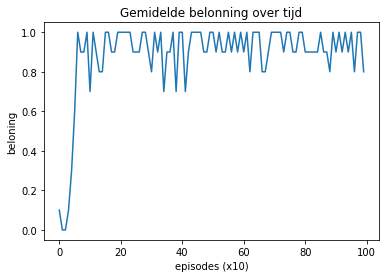

In [7]:
width = 10   # Width is de grote van elke bin
result1 = rList[:(rList.size // width * width)].reshape(-1, width).mean(axis=1)
plt.plot(result1)
plt.title("Gemidelde belonning over tijd")
plt.xlabel("episodes (x10)")
plt.ylabel("beloning")
plt.show()

> Het omslagpunt ligt ongeveer bij 100 episodes

* Plot ook de gemiddelde hoeveelheid stappen die er gemaakt zijn in bins van 10. Hoe kort is de korste route tot succes waar het model op uitkomt? Hoe verhoudt dit zich tot de werkelijke korste route?

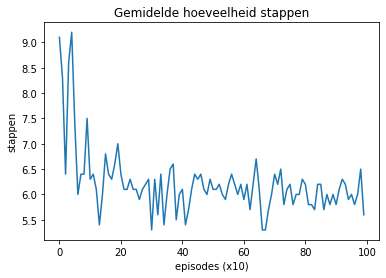

In [8]:
width = 10   # Width is de grote van elke bin
result1 = jList[:(jList.size // width * width)].reshape(-1, width).mean(axis=1)
plt.plot(result1)
plt.title("Gemidelde hoeveelheid stappen")
plt.xlabel("episodes (x10)")
plt.ylabel("stappen")
plt.show()

> De werkelijke korste route bestaat uit 6 stappen. Dit lijkt op de korste route tot succes waar het model op uitkomt, het gemiddelde ligt na 100 episodes vaak rond de 6 (soms ook richting de 7).

<br> 

### Q1.c (2 punten)

Laten we nu naar de $Q$ tables gaan kijken. Zo kunnen we inspecteren welke route de robot zou lopen als deze altijd de max $Q$ zou kiezen (dus puur greedy, $\epsilon$ = 0).

Gebruik de final $Q$ table die `q_learn()` aan het eind geeft. Hierbij is elke rij een state, met de vier acties die mogelijk zijn. Dus `output[2][9,:]` geeft de Q values van de vier acties die je kan doen in state 9. 

Zorg dat je een lijst krijgt ('Qmax') met voor elke state de actie die de hoogste Q value heeft. Representeer hier elke actie met een getal (0 = links, 1 = beneden, 2 = rechts, 3 = boven). Plot vervolgens deze lijst in een grid: 

```python
print("0=links, 1=beneden, 2=rechts, 3=boven")
Qmax=np.asarray(Qmax).reshape((4,4))
print(Qmax)

```

* Ga nu na hoe de robot loopt, gaat deze links of rechts langs het wak linksboven op de kaart?

In [9]:
Qmax = np.argmax(Q, axis=1)
print("0=links, 1=beneden, 2=rechts, 3=boven")
Qmax=np.asarray(Qmax).reshape((4,4))
print(Qmax)

0=links, 1=beneden, 2=rechts, 3=boven
[[1 0 0 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


> De robot gaat rechts langs het wak lingsboven, en dan 3 keer naar beneden en als laatst nog een keer naar rechts.

<br>

---

## 2. Changes in the environment

We kijken nu naar hoe de robot zich op glad ijs beweegt. In deze omgeving zal hij dus af en toe een willekeurige kant op schuiven. Laad de omgeving opnieuw met `is_slippery = True`. Deze omgeving is als trainingsomgeving bedacht omdat er vaak ruis (noise) zit in de omgeving (of in perceptie zelf) en soms dingen dus net anders lopen dan verwacht. Een robust algortime kan hier dan ook mee leren omgaan. 

Het gebruiken van een algoritme dat in een simulatie van een perfecte wereld is getest, zoals hierboven, kan tot catastrofale uitkomsten leiden in de echte wereld (waarbij de weg ineens glad kan zijn of er een sterke storm opsteekt, er is altijd wel iets onvoorzien).

In [10]:
#let's load the Frozen lake environment
#slippery means that sometimes the robot will slip on the ice and move in a random direction 
env_slip = gym.make('FrozenLake-v1',map_name="4x4",is_slippery=True)

<br>

### Q2.a (5 punten)
Run hetzelfde `q_learn` algoritme met dezelfde parameterwaardes als hierboven. 
* Laat de gemiddelde score zien, en hoe de gemiddelde beloning en het aantal stappen met de tijd verandert. 
* Vergelijk dit met de non-slippery omgeving van hiervoor, noem de meest opvallende verschillen en leg uit waarom we die zien. 

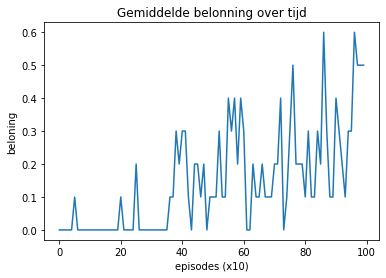

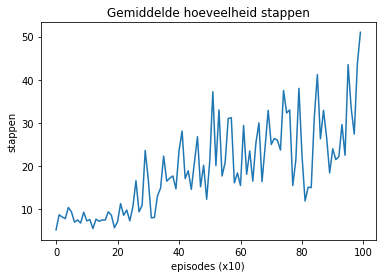


average score:  0.144


In [11]:
rList, jList, Q = q_learn(env_slip, num_episodes=1000)

width = 10 
r = rList[:(rList.size // width * width)].reshape(-1, width).mean(axis=1)
j = jList[:(jList.size // width * width)].reshape(-1, width).mean(axis=1)

plt.plot(r)
plt.title("Gemiddelde belonning over tijd")
plt.xlabel("episodes (x10)")
plt.ylabel("beloning")
plt.show()

plt.plot(j)
plt.title("Gemiddelde hoeveelheid stappen")
plt.xlabel("episodes (x10)")
plt.ylabel("stappen")
plt.show()

print("\naverage score: ", np.mean(rList))

> De gemiddelde hoeveelheid stappen is een stuk hoger met de slippery omgeving. Ook blijft de beloning een veel langere tijd laag, pas naa 800 episodes haalt het voor de eerste keer een gemiddelde beloning van 0.7. Dit komt omdat er niet een pad is dat elke keer tot het eind punt zal leiden, aangezien het soms een willekeurige kant op schuift. De gemiddelde score van de robot is 0.231.

### Loading the 8x8 environment

We gaat het nu wat moeilijker maken en maken het bevroren meer wat groter. Laad nu het **niet gladde** grotere ijsmeer in:
```python
env = gym.make('FrozenLake-v1',map_name="8x8",is_slippery=False)
```

In [12]:
#let's load the Frozen lake environment
env_8x8 = gym.make('FrozenLake-v1',map_name="8x8",is_slippery=False)

### Q2.b (4 punten)
Het nieuwe meer is 8x8 maar verder helemaal hezelfde. We kunnen dan ook weer hetzelfde `q_learn()` hier op los laten. Doe dit, met weer dezelfde parameterwaardes als je eerder bij de 4x4 hebt gebruikt. 
* Rapporteer wederom hoe goed de robot het doet in termen van verkregen beloningen en aantal stappen genomen. 
* Zie je ook een omslag punt? (probeer een paar keer als het model niet lijkt te leren)

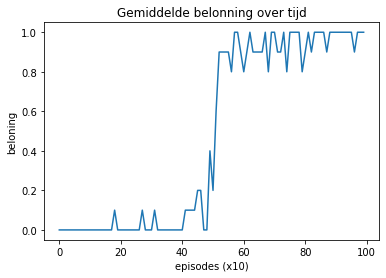

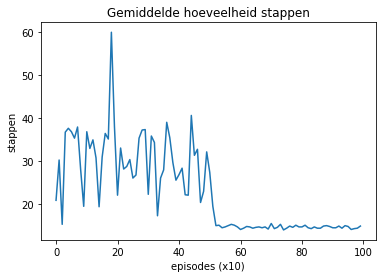

In [13]:
rList, jList, Q = q_learn(env_8x8, num_episodes=1000)

width = 10 
r = rList[:(rList.size // width * width)].reshape(-1, width).mean(axis=1)
j = jList[:(jList.size // width * width)].reshape(-1, width).mean(axis=1)

plt.plot(r)
plt.title("Gemiddelde belonning over tijd")
plt.xlabel("episodes (x10)")
plt.ylabel("beloning")
plt.show()

plt.plot(j)
plt.title("Gemiddelde hoeveelheid stappen")
plt.xlabel("episodes (x10)")
plt.ylabel("stappen")
plt.show()

> Er is een omslagpunt te zien bij ongeveer 700 episodes. Vanaf dat moment haalt de robot vaak een gemiddelde beloning van 1.0 en het heeft steeds gemiddeld maar ongeveer 15 stappen nodig vanaf dit omslagpunt. 

---

## 3. Introducing Intuitive Physics

In het grid van 8x8 zien we dat de robot veel trials nodig heeft om een simpele taak op te lossen. En dit is nog maar een erg simpele wereld met slechts 64 states! We gaan nu proberen of we de Q-learning robot een beetje kunnen helpen sneller te leren. Zoals we in het college gezien hebben (en zie [hier](https://arxiv.org/pdf/1802.10217.pdf)) zijn mensen heel snel in het leren van computer games omdat ze hun kennis over de wereld toepassen op de spelwereld. Laten we dat hier ook proberen.

### Q3.a (10 punten)

Implementeer een nieuwe `q_learn_intuition` met drie toevoegingen die je makkelijk aan of uit kunt zetten, zodat je het algoritme met en zonder deze toevoeging kunt testen:
* Negatieve reward
* Muren
* Cognitieve map

__Negatieve reward__ <br>
Om te beginnen is het voor de robot niet heel duidelijk dat in een wak vallen een slecht idee is. De beloning die er bij hoort is nu nul. Het is voor mensen duidelijk dat in een wak vallen niet goed is voor het behalen van het doel. Zo kan je dus de volgende kleine aanpassing maken:

```python
 if d and r == 0:
     r = -1
```

Dit moet direct na de `env.step()` stap waarbij `r` is bepaald. Door een negatieve reward te gebruiken zal het model sneller leren wakken te vermijden.

__Muren__ <br>
Het is nu voor de robot nog mogelijk om tegen muren aan te botsen zonder daar iets over te leren. Wanneer de robot bijvoorbeeld vanaf state 3 (in de rechter boven hoek) naar rechts of boven probeert te lopen, zal de nieuwe state weer 3 zijn. Leer de robot af om dit te doen.

__Cognitieve map__ <br>
Leer de robot daarnaast dat als je in een wak loopt, je ook in dit wak loopt als je van een andere kant naar hetzelfde hokje loopt. Stel je loopt van boven in een wak, leer dan meteen dat je ook in datzelfde wak loopt als je er van links, rechts of van onder in loopt. Met andere woorden: introduceer een minimale intuitive physics! <br>
   
   *Hint: Houd hierbij rekening met dat sommige wakken tegen de randen aanzitten, update geen states die niet bestaan*

Je kan naar de Q tables kijken om te zien of jouw implementatie gewerkt heeft.

In [14]:
def q_learn_intuition(env, alpha=.8, gamma=.95, epsilon=.1, num_episodes=2000, nr = False, m = False, cm = False):
    states = env.observation_space.n
    actions = env.action_space.n
    Q = np.zeros([states,actions])

    jList = []
    rList = []

    for _ in range(num_episodes):
        s = env.reset()
        rAll = 0
        d = False
        j = 0

        while j < 100: 
            j+=1
            s = s[0] if type(s) is tuple else s

            if random.random() < epsilon:
                a = random.randint(0,3)
            else:
                max_Q = np.max(Q[s, :])
                options = np.where(Q[s,:] == max_Q)[0]
                a = random.choice(options)
            
            s1, r, d, _, *_ = env.step(a)
            
            # negative reward
            if nr:
                if d and r == 0:
                    r = -1
                    
            # muren
            if m:
                if s == s1:
                    r = -1
                    
            delta = r + gamma * np.max(Q[s1, :]) - Q[s,a]
            Q[s,a] = Q[s,a] + alpha*delta
            
            # cognitive map
            if cm:
                if (d and r == 0) or r == -1:
                    other = [0, 1, 2, 3]
                    other.remove(a)
                    for i in other:
                        delta = r + gamma * np.max(Q[s1, :]) - Q[s,i]
                        Q[s,i] = Q[s,i] + alpha*delta
                    

            rAll += r    
            
            if d:
                break
            
            s = s1[0] if type(s1) is tuple else s1 

        epsilon = epsilon*.999
        jList.append(j)
        rList.append(rAll)

    return (np.array(rList), np.array(jList), Q)

### Q3.b (4 punten)

Run de verschillende implementaties van het model met geen, een of een combinatie van elementen van kennis. Run elk model 20 keer voor 500 episodes en vergelijk de average rewards. Run alles voor de zekerheid een paar keer om te voorkomen dat er door toevalligheid een raar resultaat uit komt.  Beschrijf hoe elk element wel of niet bijdraagt aan beter of sneller leren. 

De output moet er dus ongeveer zo uit zien:

```python
Baseline average score: 
Neg_reward average score: 
Muren average score: 
Cog_map average score: 
Neg_reward + muren average score: 
Neg_reward + cog_map average score:
Muren + cog_map average score:
Neg_reward + muren + cog_map  average score:
```

In [15]:
r_base = 0
r_nrwd = 0
r_mrn = 0
r_cogm = 0
r_nrwd_mrn = 0
r_nrwd_cogm = 0
r_mrn_cogm = 0
r_nrwd_mrn_cogm = 0
for _ in range(20):
    r_b, _, _ = q_learn_intuition(env_8x8, num_episodes=500)
    r_base += np.mean(r_b)/20
    r_nr, _, _ = q_learn_intuition(env_8x8, num_episodes=500, nr=True)
    r_nrwd += np.mean(r_nr)/20
    r_m, _, _ = q_learn_intuition(env_8x8, num_episodes=500, m=True)
    r_mrn += np.mean(r_m)/20
    r_cm, _, _ = q_learn_intuition(env_8x8, num_episodes=500, cm=True)
    r_cogm += np.mean(r_cm)/20
    r_nr_m, _, _ = q_learn_intuition(env_8x8, num_episodes=500, nr=True, m=True)
    r_nrwd_mrn += np.mean(r_nr_m)/20
    r_nr_cm, _, _ = q_learn_intuition(env_8x8, num_episodes=500, nr=True, cm=True)
    r_nrwd_cogm += np.mean(r_nr_cm)/20
    r_m_cm, _, _ = q_learn_intuition(env_8x8, num_episodes=500, m=True, cm=True)
    r_mrn_cogm += np.mean(r_m_cm)/20
    r_nr_m_cm, _, _ = q_learn_intuition(env_8x8, num_episodes=500, nr=True, m=True, cm=True)
    r_nrwd_mrn_cogm += np.mean(r_nr_m_cm)/20
    
print("Baseline average score:                       ",r_base)
print("Neg_reward average score:                     ",r_nrwd)
print("Muren average score:                          ",r_mrn)
print("Cog_map average score:                        ",r_cogm)
print("Neg_reward + muren average score:             ",r_nrwd_mrn)
print("Neg_reward + cog_map average score:           ",r_nrwd_cogm)
print("Muren + cog_map average score:                ",r_mrn_cogm)
print("Neg_reward + muren + cog_map  average score:  ",r_nrwd_mrn_cogm)

Baseline average score:                        0.07860000000000002
Neg_reward average score:                      0.4091999999999999
Muren average score:                           -0.32960000000000006
Cog_map average score:                         0.0196
Neg_reward + muren average score:              0.1557
Neg_reward + cog_map average score:            0.031299999999999994
Muren + cog_map average score:                 -0.14800000000000002
Neg_reward + muren + cog_map  average score:   -0.30590000000000006


> Negative reward geeft de hoogste average score. Cognitive map voegt niet zoveel toe, het heeft een iets hogere average score dan de baseline. Muren geeft een negatieve average score, dit is omdat de reward van tegen een muur lopen nu ook -1 is. Dit zorgt ervoor dat hij aan het begin een hoge negatieve score heeft. De combinaties werken ook niet zo goed (waarschijnlijk omdat de score omlaag word gehaald door muren)

### Q3.c  (3 punten)

Laat van het beste model (run een aantal keer om te besluiten welke dat is) ook nog de grafieken van beloning en pad lengte zien, zodat je die kan vergelijken met die hierboven voor het baseline model. Beschrijf wat je ziet.

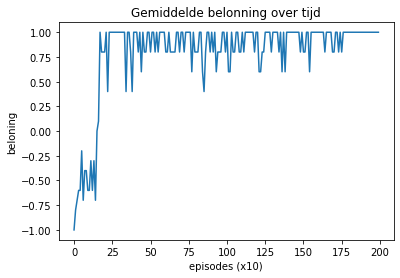

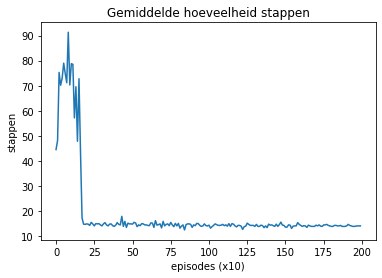

In [16]:
rList, jList, Q = q_learn_intuition(env_8x8, nr=True)

width = 10 
r = rList[:(rList.size // width * width)].reshape(-1, width).mean(axis=1)
j = jList[:(jList.size // width * width)].reshape(-1, width).mean(axis=1)

plt.plot(r)
plt.title("Gemiddelde belonning over tijd")
plt.xlabel("episodes (x10)")
plt.ylabel("beloning")
plt.show()

plt.plot(j)
plt.title("Gemiddelde hoeveelheid stappen")
plt.xlabel("episodes (x10)")
plt.ylabel("stappen")
plt.show()

> Aan het begin heeft deze robot juist een extra hoge gemiddelde hoeveelheid stappen, maar het omslagpunt komt ook veel eerder. Het omslag punt bij deze robot zit al rond de 150 episodes. Daarna heeft het consistent een lage gemiddelde hoeveelheid stappen dichtbij de ware minimale hoeveelheid stappen.

### Q3.d More common sense (6 punten)
Verzin zelf nog een ingreep die het model beter en sneller zou kunnen laten leren. Denk dan vooral na over hoe mensen, zoals jij, het spel zouden spelen. Laat zien of, en zo ja hoeveel beter jouw model werkt. 

Laat zien hoe jouw implementatie een verbetering is op het baseline model, maar ook of het nog wat toevoegd aan het best model van vraag Q3.b. 

In [17]:
def q_learn_comsen(env, alpha=.8, gamma=.95, epsilon=.1, num_episodes=2000):
    states = env.observation_space.n
    actions = env.action_space.n
    Q = np.zeros([states,actions])

    jList = []
    rList = []

    for _ in range(num_episodes):
        s = env.reset()
        rAll = 0
        d = False
        j = 0

        while j < 100: 
            j+=1
            s = s[0] if type(s) is tuple else s

            if random.random() < epsilon:
                a = random.randint(1,2)
            else:
                max_Q = np.max(Q[s, :])
                options = np.where(Q[s,:] == max_Q)[0]
                a = random.choice(options)
            
            s1, r, d, _, *_ = env.step(a)
            
            if d and r == 0:
                r = -1
                
            delta = r + gamma * np.max(Q[s1, :]) - Q[s,a]
            Q[s,a] = Q[s,a] + alpha*delta
            
            rAll += r    
            
            if d:
                break
            
            s = s1[0] if type(s1) is tuple else s1 

        epsilon = epsilon*.999
        jList.append(j)
        rList.append(rAll)

    return (np.array(rList), np.array(jList), Q)

r1,_,_ = q_learn_comsen(env_8x8)
r2,_,_ = q_learn_intuition(env_8x8)
print(np.mean(r1))
print(np.mean(r2))

0.8895
0.6385


> Dit common sense model doet iets anders tijdens de exploratie. Aangezien de startpositie linksboven is, zouden mensen als ze niet weten wat de beste stap is kiezen tussen rechts of beneden. Dit zijn namelijk de twee stappen die je verder weg brengen van het startpunt. Je kan zien dat voor dit model de gemiddelde reward hoger is dan het intuition model met negative rewards.

## Q Networks

We hebben nu gewerkt met een kleine wereld met maar maximaal 64 states. De echte wereld, en veel leuke spelletjes, hebben natuurlijk een veel grotere state space, en dan wordt het al snel erg lastig om nog een Q table te gaan bijhouden. Dit is waar Q netwerken heel handig zijn, en dan met name Deep Q Networks (DQN). Een deep neural network kan helpen de state space een stuk beter generaliseerbaar te maken, en vergelijkbare Q-values toekennen aan states die veel op elkaar lijken, wat een hele waardevolle eigenschap blijkt (zie bijv. de oorspronkelijke DQN paper over Atari games leren spelen [hier](https://arxiv.org/pdf/1312.5602v1.pdf)).

We gaan een Deep Q Netwerk in elkaar zetten in Google Colab. Open daarvoor eerst `Assignment_3_Uitleg_Colab`.